In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "g_and_k_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users

--- Step 1: Load model and create simulator ---
Model loaded: GAndKModel({'model_type': 'GAndKModel', 'model_class': 'GAndKModel', 'model_args': {'prior_bounds': {'A': [0.0, 10.0], 'B': [0.0010000000474974513, 10.0], 'g': [0.0, 10.0], 'k': [0.0, 10.0]}, 'dim': 1, 'n_obs': 100, 'parameter_of_interest': 'A'}})
DEBUG: Summary statistics for data = (100, 1)


INFO:abcnre.simulation.simulator:Created temporary observed data for prior sampling mode


In [2]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(1)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "regressor",
                          lr_scheduler_name = "constant",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)
# simulator.train_summary_network(subkey_learn, regressor_config)

# key, subkey_check = jax.random.split(key)
# simulator.check_summary_stats_correlation(
#     subkey_check,
#     n_samples=10000)

INFO:abcnre.training.config:Using constant lr_scheduler with base learning_rate from training config
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: regressor_deepset_default_default (task: regressor)


--- Step 1.5 : Learn Summary Stats (Optional) ---


In [3]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")
import jax.numpy as jnp
model = simulator.model

key, key_prior = jax.random.split(key)
true_theta = model.get_prior_sample(key_prior)

true_phi = 5.
true_theta = jnp.ones(4) * true_phi


key, subkey_sample = jax.random.split(key)
x_obs = model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs shape: {x_obs.shape}")

quantile_distance = .1
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
DEBUG: Summary statistics for data = (100, 1)
Observation x_obs shape: (100, 1)
DEBUG: Summary statistics for data = (100, 1)
DEBUG: Summary statistics for data = (100, 1)
DEBUG: Discrepancy function called with data1 = (9, 1) data2 = (9, 1)


INFO:abcnre.simulation.simulator:Computed epsilon = 5382.955078 for 10.0% quantile


Set epsilon for quantile distance 1.0.


INFO:abcnre.simulation.simulator:Computed epsilon = 8756.796875 for 50.0% quantile


Set epsilon for quantile distance 0.5.


INFO:abcnre.simulation.simulator:Computed epsilon = 7968.571777 for 25.0% quantile


Set epsilon for quantile distance 0.25.


INFO:abcnre.simulation.simulator:Computed epsilon = 5292.905762 for 10.0% quantile


Set epsilon for quantile distance 0.1.


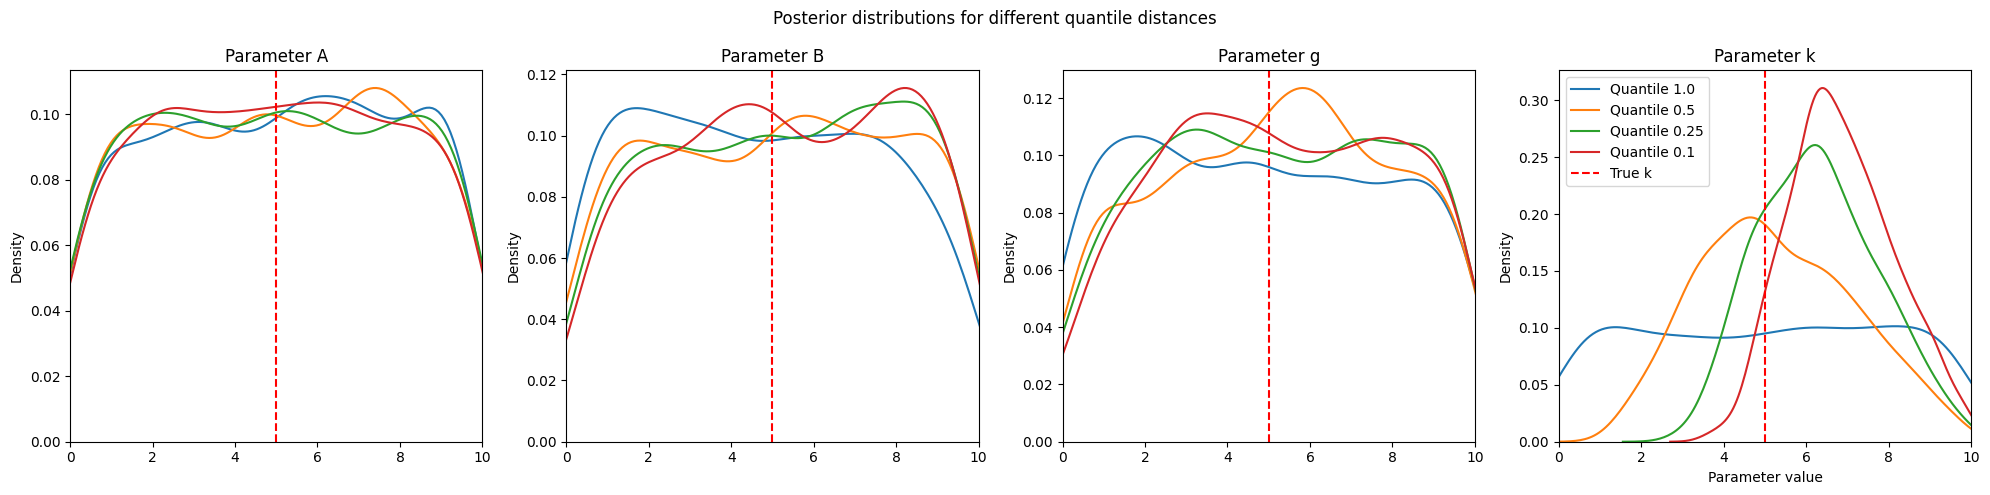

In [4]:
quantiles = [1. , .5, .25, .1]
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(1, 4, figsize=(20,5))
for quantile_distance in quantiles:
    key, subkey_epsilon = jax.random.split(key)
    simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)
    print(f"Set epsilon for quantile distance {quantile_distance}.")
    key, subkey_sample = jax.random.split(key)
    n_sample = 1000
    results = simulator.sampler.sample(subkey_sample, n_sample)
    thetas = results.theta
    sns.kdeplot(thetas[:,0], ax=ax[0], label=f"Quantile {quantile_distance}")
    sns.kdeplot(thetas[:,1], ax=ax[1], label=f"Quantile {quantile_distance}")
    sns.kdeplot(thetas[:,2], ax=ax[2], label=f"Quantile {quantile_distance}")
    sns.kdeplot(thetas[:,3], ax=ax[3], label=f"Quantile {quantile_distance}")
    
ax[0].set_title("Parameter A")
ax[1].set_title("Parameter B")
ax[2].set_title("Parameter g")
ax[3].set_title("Parameter k")
ax[0].set_xlim(0, 10)
ax[1].set_xlim(0, 10)
ax[2].set_xlim(0, 10)
ax[3].set_xlim(0, 10)
ax[0].axvline(true_theta[0], color='red', linestyle='--', label='True A')
ax[1].axvline(true_theta[1], color='red', linestyle='--', label='True B')
ax[2].axvline(true_theta[2], color='red', linestyle='--', label='True g')
ax[3].axvline(true_theta[3], color='red', linestyle='--', label='True k')
plt.suptitle("Posterior distributions for different quantile distances")
plt.xlabel("Parameter value")
plt.ylabel("Density")
plt.tight_layout()

    
plt.legend()
plt.show()

In [5]:
key = jax.random.PRNGKey(1)
key, key_theta, key_x_obs = jax.random.split(key, 3)
k_parameters = 4
true_theta = jax.random.uniform(key_theta, shape= (1, k_parameters))*10.0


In [6]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator.yaml


--- Step 2.2: Save model to YAML (Optional) ---


In [7]:

print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

from abcnre.utils.comparison import are_simulators_equivalent

simulators_match = are_simulators_equivalent(simulator, simulator_loaded)
print(f"Simulators match: {'YES' if simulators_match else 'NO'}")

INFO:abcnre.simulation.io:Loaded model: GAndKModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = 5292.905762


--- Step 2.3 : Load model from YAML and check (Optional) ---
DEBUG: Summary statistics for data = (100, 1)
Simulators match: YES


In [8]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="conditioned_deepset",
                          network_size = "xl",
                          training_size = "heavy",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_xl_heavy (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [9]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [10]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")


key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)  # Store few phi samples

INFO:abcnre.inference.estimator:Using ConditionedDeepSet without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: ConditionedDeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.001
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 512
INFO:abcnre.training.components.metrics:   Samples/epoch: 51200
INFO:abcnre.training.components.metrics:   Max epochs: 500
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.metrics:   Phi storage: 10000 values
INFO:abcnre.training.components.setup:Setting up classifier training
INFO:abcnre.training.components.setup:Epochs: 500, Batch size: 512, Bat

--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for ConditionedDeepSet network
INFO:abcnre.training.registry:Created ConditionedDeepSet network (from 'ConditionedDeepSet') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.1, 'pooling_type': 'mean', 'conditioning_mode': 'concat', 'phi_hidden_dims': [128, 64, 32], 'rho_hidden_dims': [128, 64, 32], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: ConditionedDeepSet


KeyboardInterrupt: 

In [ ]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Rec

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---
{'model_type': 'GAndKModel', 'model_class': 'GAndKModel', 'model_args': {'prior_bounds': {'A': [0.0, 10.0], 'B': [0.0010000000474974513, 10.0], 'g': [0.0, 10.0], 'k': [0.0, 10.0]}, 'dim': 1, 'n_obs': 100, 'parameter_of_interest': 'A'}}


In [ ]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)
from abcnre.utils.comparison import are_estimators_equivalent

estimators_match = are_estimators_equivalent(estimator, estimator_loaded)
print(f"Estimators match: {'YES' if estimators_match else 'NO'}")

INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GAndKModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = 131020816.000000
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for ConditionedDeepSet network
INFO:abcnre.training.registry:Created ConditionedDeepSet network (from 'ConditionedDeepSet') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.1, 'pooling_type': 'mean', 'conditioning_mode': 'concat', 'phi_hidden_dims': [128, 64, 32], 'rho_hidden_dims': [128, 64, 32], 

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Estimators match: NO


/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


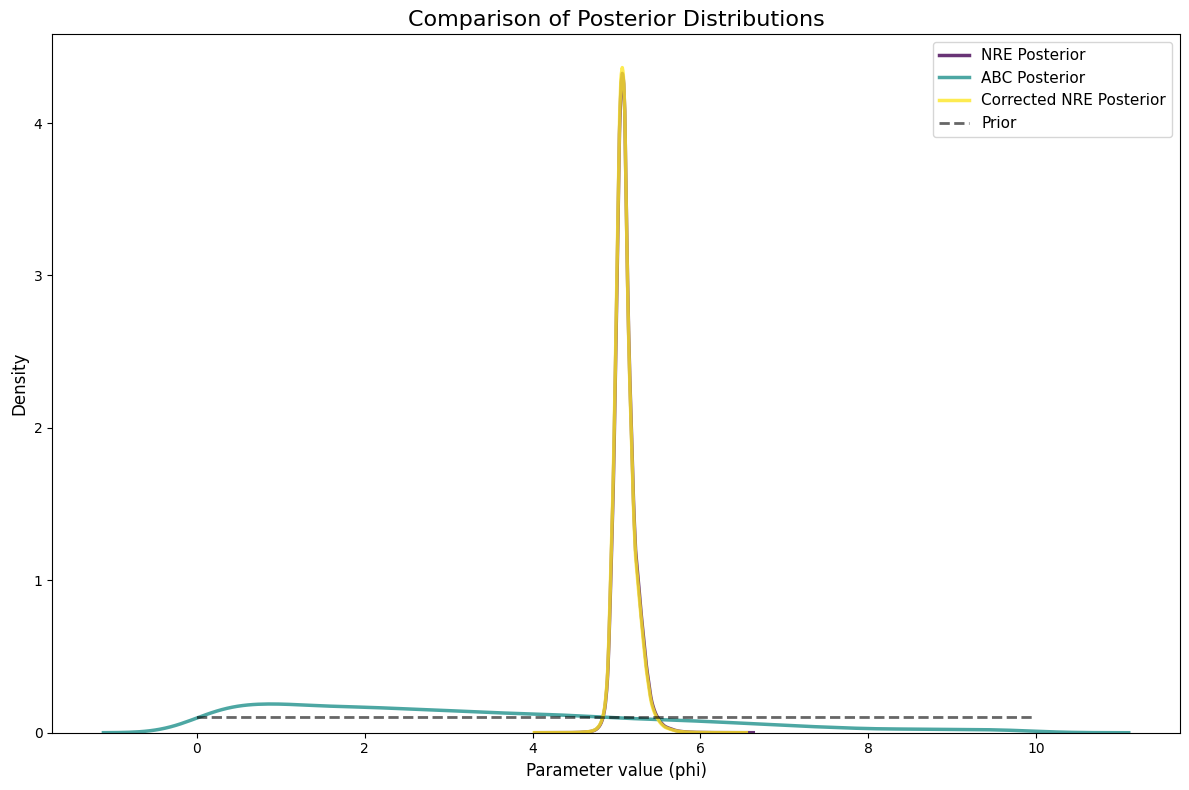

In [ ]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
import numpy as np

abc_phi_samples = estimator.stored_phis
min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

n_grid = 10000  # Number of grid points for the posterior distribution
abc_phi_grid = np.linspace(min_phi, max_phi, n_grid)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(estimator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, 
                                       initial_bounds=(min_phi, max_phi), 
                                        n_grid_points=n_grid)

# Get prior for plotting
prior_pdf_values = simulator.model.prior_phi_pdf(abc_phi_grid)

# true_grid, true_pdf = get_normalized_pdf(simulator.model.get_posterior_phi_distribution(simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unnormalized_corrected_nre_pdf(estimator)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
                                    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
                                    initial_bounds=(min_phi, max_phi),
                                    n_grid_points=n_grid
)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=n_grid
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        # 'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(abc_phi_grid, prior_pdf_values),
    # xlim=(2,7)
    # save_path=output_dir / "posterior_comparison.png"
)




In [ ]:
# from abcnre.diagnostics.calibration import run_abc_sbc
# from abcnre.diagnostics.viz import plot_sbc_ranks

# # --- Step 7: Simulation-Based Calibration (SBC) ---
# print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
# import jax
# key  = jax.random.PRNGKey(42)
# num_posterior_samples = 128  
# sbc_results = run_abc_sbc(
#     key=key,
#     estimator=estimator,
#     num_sbc_rounds=10,
#     num_posterior_samples=num_posterior_samples
# )


# plot_sbc_ranks(sbc_results)

In [ ]:
# print("\n--- Step 8: Creating Samplers and Running Metrics ---")
# from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf, get_sampler_from_pdf
# from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv


# # Define bounds for posterior calculation based on reference samples
# min_phi = np.min(abc_phi_samples) - 1.0
# max_phi = np.max(abc_phi_samples) + 1.0

# # --- Create all necessary sampler functions ---
# # A sampler is a function that takes (n_samples, key) and returns samples

# unorm_nre_pdf = get_unnormalized_nre_pdf(estimator)
# nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# unorm_corrected_nre_pdf = get_unnormalized_corrected_nre_pdf(
#     estimator, phi_samples=abc_phi_samples
# )
# corrected_nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_corrected_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# true_sampler = simulator.get_true_posterior_samples

# # abc_sampler = lambda: key, n_s:  simulator.get_abc_posterior_samples()

# # --- Run the metrics suite ---
# approx_samplers_dict = {
#     "NRE_Standard": nre_sampler,
#     "NRE_Corrected": corrected_nre_sampler,
#     # "ABC": 
# }

# # The key here will be split inside the function for each sampler
# key = jax.random.PRNGKey(123)
# all_metrics_results = generate_and_evaluate_metrics(
#     key=key,
#     true_sampler=true_sampler,
#     approx_samplers_dict=approx_samplers_dict,
#     n_samples=5000
# )

# print("\n--- Quantitative Results ---")
# save_metrics_to_csv(all_metrics_results, results_dir / "diagnostics_metrics.csv")

# CLI Commands Examples

You can now use the new CLI commands to train summary statistics and NRE separately:

## Train Summary Statistics
```bash
# Train summary statistics for an existing simulator
abcnre train_summary_stats ./results/simulator/simulator.yaml ./cli/templates/regressor_configs/deepset_fast.yaml --check-correlation

# Or with custom output
abcnre train_summary_stats ./results/simulator/simulator.yaml ./my_regressor_config.yaml --output-path ./updated_simulator.yaml
```

## Train NRE
```bash
# Train NRE for an existing estimator
abcnre train_nre ./results/estimator/estimator.yaml ./cli/templates/classifier_configs/conditioned_deepset_default.yaml

# Or with custom parameters
abcnre train_nre ./results/estimator/estimator.yaml ./my_classifier_config.yaml --n-phi-to-store 20000 --output-path ./trained_estimator.yaml
```

These commands are useful for:
- **Retraining** with different configurations
- **Incremental training** workflows
- **Batch processing** multiple models
- **Fine-tuning** specific components